# denoiSplit: joint splitting and unsupervised denoising
In this notebook, we tackle the problem of joint splitting and unsupervised denoising, which has a usecase in the field of fluorescence microscopy. From a technical perspective, given a noisy image $x$, the goal is to predict two images $c_1$ and $c_2$ such that $x = c_1 + c_2$. In other words, we have a superimposed image $x$ and we want to predict the denoised estimates of the constituent images $c_1$ and $c_2$. It is important to note that the network is trained with noisy data and the denoising is done in a unsupervised manner. 

For this, we will use [denoiSplit](https://arxiv.org/pdf/2403.11854.pdf), a recently developed approach for this task. In this notebook we train denoiSplit and later evaluate it on one validation frame. The overall schema for denoiSplit is shown below:
<!-- Insert a figure -->
<!-- ![Schema](imgs/teaser.png) -->
<img src="imgs/teaser.png" alt="drawing" width="800"/>


Here, we look at CCPs (clathrin-coated pits) vs ER (Endoplasmic reticulum) task, one of the tasks tackled by denoiSplit which is generated from [BioSR](https://figshare.com/articles/dataset/BioSR/13264793) dataset. For this task, the noise is synthetically added. 

In [1]:
# a useful library developed by Google for maintaining the ML configs.
! pip install ml-collections

In [2]:
import sys
sys.path.append('../')
sys.path

['/home/ashesh.ashesh/code/denoiSplit/notebooks',
 '/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/_pdbpp_path_hack',
 '/home/ashesh.ashesh/code/Disentangle',
 '/localscratch/miniforge3/envs/usplit_vdi/lib/python39.zip',
 '/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9',
 '/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/lib-dynload',
 '',
 '/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages',
 '/home/ashesh.ashesh/code/RI-SSIM',
 '../']

## Set directories 
In the next cell, we enumerate the necessary fields for this task.

In [3]:
import os

data_dir = "/group/jug/ashesh/data/BioSR/"  # FILL IN THE PATH TO THE DATA DIRECTORY
work_dir = "."
tensorboard_log_dir = os.path.join(work_dir, "tensorboard_logs")
os.makedirs(tensorboard_log_dir, exist_ok=True)

In [4]:
import sys
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


from denoisplit.analysis.plot_utils import clean_ax
from denoisplit.configs.biosr_config import get_config
from denoisplit.training import create_dataset
from denoisplit.nets.model_utils import create_model
from denoisplit.core.metric_monitor import MetricMonitor
from denoisplit.scripts.run import get_mean_std_dict_for_model
from denoisplit.core.data_split_type import DataSplitType
from denoisplit.scripts.evaluate import get_highsnr_data
from denoisplit.analysis.mmse_prediction import get_dset_predictions
from denoisplit.data_loader.patch_index_manager import GridAlignement
from denoisplit.scripts.evaluate import avg_range_inv_psnr, compute_multiscale_ssim

/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.11 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


<div class="alert alert-block alert-warning"><h3>
    Several Things to try (try some ;) ):</h3>
    <ol>
        <li>Run once with unchanged config to see the performance. </li>
        <li>Increase the noise (double the gaussian noise?) and see how performance degrades. </li>
        <li> Increase the max_epochs, if you want to get better performance. </li>
        <li> For faster training ( but compromising on performance), reduce the number of hierarchy levels and/or the channel count by modifying <em>config.model.z_dims</em>.</li> 
    </ol>
</div>

## Config 

In [5]:
# load the default config.
config = get_config()
# Channge the noise level
config.data.poisson_noise_factor = (
    1000  # 1000 is the default value. noise increases with the value.
)
config.data.synthetic_gaussian_scale = (
    5000  # 5000 is the default value. noise increases with the value.
)

# change the number of hierarchy levels.
config.model.z_dims = [128, 128, 128, 128]

# change the training parameters
config.training.lr = 3e-3
config.training.max_epochs = 10
config.training.batch_size = 8
config.training.num_workers = 4

config.workdir = "."

## Create the dataset and pytorch dataloaders. 

In [6]:
train_dset, val_dset = create_dataset(config, data_dir)
mean_dict, std_dict = get_mean_std_dict_for_model(config, train_dset)

Loaded from /group/jug/ashesh/data/BioSR/ Channels:2 ER/GT_all.mrc,CCPs/GT_all.mrc Mode:Train
Adding Poisson noise with factor 1000.	Adding Gaussian noise with scale 5000. Moreover, input has dependent noise
[MultiChDloader] Sz:128 Train:1 N:44 NumPatchPerN:49 NormInp:True SingleNorm:True Rot:False RandCrop:True Q:1 SummedInput:False ReplaceWithRandSample:False BckQ:0.0
Loaded from /group/jug/ashesh/data/BioSR/ Channels:2 ER/GT_all.mrc,CCPs/GT_all.mrc Mode:Val
Adding Poisson noise with factor 1000.	Adding Gaussian noise with scale 5000. Moreover, input has dependent noise
[MultiChDloader] Sz:128 Train:0 N:5 NumPatchPerN:49 NormInp:True SingleNorm:True Rot:False RandCrop:False Q:1 SummedInput:False ReplaceWithRandSample:False BckQ:0.0


## Inspecting the training data generated using the above config.
<div class="alert alert-block alert-warning">
If you want to change the noise, then you should change the config first and run the following cell again to see how the training data changes in terms of noise.
</div>


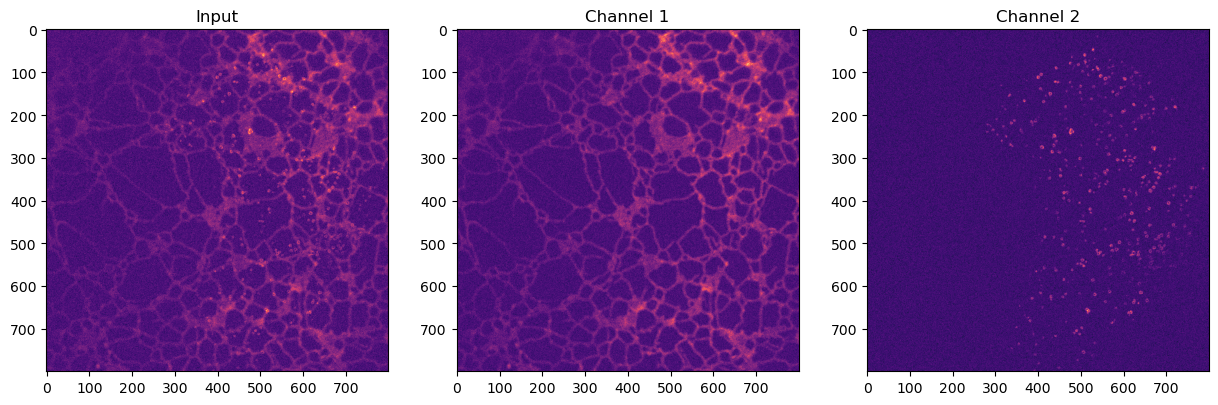

In [7]:
val_dset.set_img_sz(800, 64)
inp, tar = val_dset[0]
_,ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(inp[0], cmap='magma')
ax[0].set_title('Input')
ax[1].imshow(tar[0], cmap='magma')
ax[1].set_title('Channel 1')
ax[2].imshow(tar[1], cmap='magma')
ax[2].set_title('Channel 2')

val_dset.set_img_sz(config.data.image_size, config.data.image_size)

In [8]:
batch_size = config.training.batch_size
train_dloader = DataLoader(
    train_dset,
    pin_memory=False,
    num_workers=config.training.num_workers,
    shuffle=True,
    batch_size=batch_size,
)
val_dloader = DataLoader(
    val_dset,
    pin_memory=False,
    num_workers=config.training.num_workers,
    shuffle=False,
    batch_size=batch_size,
)

## Create the model.
Here, we instantiate the [denoiSplit model](https://arxiv.org/pdf/2403.11854.pdf). For simplicity, we have disabled the noise model. For enabling the noise model, one would additionally have to train a denoiser. The next step would be to create a noise model using the noisy data and the corresponding denoised predictions. 

In [9]:
model = create_model(config, mean_dict, std_dict)
model = model.cuda()

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmp70p8xjxg
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmp70p8xjxg/_remote_module_non_scriptable.py


[3, 3] [1, 1]
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[GaussianLikelihood] PredLVar:pixelwise LowBLVar:-5
[LadderVAE] Stoc:True RecMode:False TethInput:False


## Start training

In [10]:
# logger = TensorBoardLogger(tensorboard_log_dir, name="", version="", default_hp_metric=False)
logger = None
trainer = pl.Trainer(
    max_epochs=config.training.max_epochs,
    gradient_clip_val=(
        None
        if model.automatic_optimization == False
        else config.training.grad_clip_norm_value
    ),
    logger=logger,
    precision=config.training.precision,
)
trainer.fit(model, train_dloader, val_dloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /home/ashesh.ashesh/code/denoiSplit/notebooks/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type               | Params
--------------------------------------------------------
0 | first_bottom_up  | Sequential         | 74.8 K
1 | bottom_up_layers | ModuleList         | 477 K 
2 | top_down_layers  | ModuleList         | 2.4 M 
3 | final_top_down   | Sequential         | 82.4 K
4 | likelihood       | GaussianLikelihood | 0     
5 |

Epoch 1:  95%|█████████▍| 256/270 [00:25<00:01, 10.10it/s, v_num=0]        

## Evaluate the model

In [ ]:
model.eval()
_ = model.cuda()
eval_frame_idx = 0
# reducing the data, just for speed
val_dset.reduce_data(t_list=[eval_frame_idx])
mmse_count = 10
overlapping_padding_kwargs = {
    "mode": config.data.get("padding_mode", "constant"),
}
if overlapping_padding_kwargs["mode"] == "constant":
    overlapping_padding_kwargs["constant_values"] = config.data.get("padding_value", 0)
val_dset.set_img_sz(
    128,
    32,
    grid_alignment=GridAlignement.Center,
    overlapping_padding_kwargs=overlapping_padding_kwargs,
)

# MMSE prediction
pred_tiled, rec_loss, logvar_tiled, patch_psnr_tuple, pred_std_tiled = (
    get_dset_predictions(
        model,
        val_dset,
        batch_size,
        num_workers=config.training.num_workers,
        mmse_count=mmse_count,
        model_type=config.model.model_type,
    )
)

# One sample prediction
pred1_tiled, *_ = get_dset_predictions(
    model,
    val_dset,
    batch_size,
    num_workers=config.training.num_workers,
    mmse_count=1,
    model_type=config.model.model_type,
)
# One sample prediction
pred2_tiled, *_ = get_dset_predictions(
    model,
    val_dset,
    batch_size,
    num_workers=config.training.num_workers,
    mmse_count=1,
    model_type=config.model.model_type,
)

## Stitching predictions

In [ ]:
from denoisplit.analysis.stitch_prediction import stitch_predictions

pred = stitch_predictions(pred_tiled, val_dset)


# ignore pixels at the [right/bottom] boundary.
def print_ignored_pixels():
    ignored_pixels = 1
    while (
        pred[
            0,
            -ignored_pixels:,
            -ignored_pixels:,
        ].std()
        == 0
    ):
        ignored_pixels += 1
    ignored_pixels -= 1
    return ignored_pixels


actual_ignored_pixels = print_ignored_pixels()
pred = pred[:, :-actual_ignored_pixels, :-actual_ignored_pixels]
pred1 = stitch_predictions(pred1_tiled, val_dset)[
    :, :-actual_ignored_pixels, :-actual_ignored_pixels
]
pred2 = stitch_predictions(pred2_tiled, val_dset)[
    :, :-actual_ignored_pixels, :-actual_ignored_pixels
]

In [ ]:
highres_data = get_highsnr_data(config, data_dir, DataSplitType.Val)

highres_data = highres_data[
    eval_frame_idx : eval_frame_idx + 1,
    :-actual_ignored_pixels,
    :-actual_ignored_pixels,
]

noisy_data = val_dset._noise_data[..., 1:] + val_dset._data
noisy_data = noisy_data[..., :-actual_ignored_pixels, :-actual_ignored_pixels, :]
model_input = np.mean(noisy_data, axis=-1)

# Qualitative performance on a random crop
denoiSplit is capable of sampling from a learned posterior.
Here we show full input frame and a randomly cropped input (300*300),
two corresponding prediction samples, the difference between the two samples (S1−S2),
the MMSE prediction, and otherwise unused high SNR microscopy crop. 
The MMSE predictions are computed by averaging 10 samples. 

In [ ]:
def add_str(ax_, txt):
    """
    Add psnr string to the axes
    """
    textstr = txt
    props = dict(boxstyle="round", facecolor="gray", alpha=0.5)
    # place a text box in upper left in axes coords
    ax_.text(
        0.05,
        0.95,
        textstr,
        transform=ax_.transAxes,
        fontsize=11,
        verticalalignment="top",
        bbox=props,
        color="white",
    )


ncols = 7
nrows = 2
sz = 300
hs = np.random.randint(0, highres_data.shape[1] - sz)
ws = np.random.randint(0, highres_data.shape[2] - sz)
_, ax = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
ax[0, 0].imshow(model_input[0], cmap="magma")

rect = patches.Rectangle((ws, hs), sz, sz, linewidth=1, edgecolor="r", facecolor="none")
ax[0, 0].add_patch(rect)
ax[1, 0].imshow(model_input[0, hs : hs + sz, ws : ws + sz], cmap="magma")
add_str(ax[0, 0], "Full Input Frame")
add_str(ax[1, 0], "Random Input Crop")

ax[0, 1].imshow(noisy_data[0, hs : hs + sz, ws : ws + sz, 0], cmap="magma")
ax[1, 1].imshow(noisy_data[0, hs : hs + sz, ws : ws + sz, 1], cmap="magma")

ax[0, 2].imshow(pred1[0, hs : hs + sz, ws : ws + sz, 0], cmap="magma")
ax[1, 2].imshow(pred1[0, hs : hs + sz, ws : ws + sz, 1], cmap="magma")

ax[0, 3].imshow(pred2[0, hs : hs + sz, ws : ws + sz, 0], cmap="magma")
ax[1, 3].imshow(pred2[0, hs : hs + sz, ws : ws + sz, 1], cmap="magma")

diff = pred2 - pred1
ax[0, 4].imshow(diff[0, hs : hs + sz, ws : ws + sz, 0], cmap="coolwarm")
ax[1, 4].imshow(diff[0, hs : hs + sz, ws : ws + sz, 1], cmap="coolwarm")

ax[0, 5].imshow(pred[0, hs : hs + sz, ws : ws + sz, 0], cmap="magma")
ax[1, 5].imshow(pred[0, hs : hs + sz, ws : ws + sz, 1], cmap="magma")


ax[0, 6].imshow(highres_data[0, hs : hs + sz, ws : ws + sz, 0], cmap="magma")
ax[1, 6].imshow(highres_data[0, hs : hs + sz, ws : ws + sz, 1], cmap="magma")
plt.subplots_adjust(wspace=0.02, hspace=0.02)
ax[0, 0].set_title("Model Input", size=13)
ax[0, 1].set_title("Target", size=13)
ax[0, 2].set_title("Sample 1 (S1)", size=13)
ax[0, 3].set_title("Sample 2 (S2)", size=13)
ax[0, 4].set_title('"S2" - "S1"', size=13)
ax[0, 5].set_title(f"Prediction MMSE({mmse_count})", size=13)
ax[0, 6].set_title("High SNR Reality", size=13)

twinx = ax[0, 6].twinx()
twinx.set_ylabel("Channel 1", size=13)
clean_ax(twinx)
twinx = ax[1, 6].twinx()
twinx.set_ylabel("Channel 2", size=13)
clean_ax(twinx)
clean_ax(ax)

# Qualitative performance on multiple random crops

In [ ]:
nimgs = 3
ncols = 7
nrows = 2 * nimgs
sz = 300
_, ax = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))

for img_idx in range(nimgs):
    hs = np.random.randint(0, highres_data.shape[1] - sz)
    ws = np.random.randint(0, highres_data.shape[2] - sz)
    ax[2 * img_idx, 0].imshow(model_input[0], cmap="magma")

    rect = patches.Rectangle(
        (ws, hs), sz, sz, linewidth=1, edgecolor="r", facecolor="none"
    )
    ax[2 * img_idx, 0].add_patch(rect)
    ax[2 * img_idx + 1, 0].imshow(
        model_input[0, hs : hs + sz, ws : ws + sz], cmap="magma"
    )
    add_str(ax[2 * img_idx, 0], "Full Input Frame")
    add_str(ax[2 * img_idx + 1, 0], "Random Input Crop")

    ax[2 * img_idx, 1].imshow(
        noisy_data[0, hs : hs + sz, ws : ws + sz, 0], cmap="magma"
    )
    ax[2 * img_idx + 1, 1].imshow(
        noisy_data[0, hs : hs + sz, ws : ws + sz, 1], cmap="magma"
    )

    ax[2 * img_idx, 2].imshow(pred1[0, hs : hs + sz, ws : ws + sz, 0], cmap="magma")
    ax[2 * img_idx + 1, 2].imshow(pred1[0, hs : hs + sz, ws : ws + sz, 1], cmap="magma")

    ax[2 * img_idx, 3].imshow(pred2[0, hs : hs + sz, ws : ws + sz, 0], cmap="magma")
    ax[2 * img_idx + 1, 3].imshow(pred2[0, hs : hs + sz, ws : ws + sz, 1], cmap="magma")

    diff = pred2 - pred1
    ax[2 * img_idx, 4].imshow(diff[0, hs : hs + sz, ws : ws + sz, 0], cmap="coolwarm")
    ax[2 * img_idx + 1, 4].imshow(
        diff[0, hs : hs + sz, ws : ws + sz, 1], cmap="coolwarm"
    )

    ax[2 * img_idx, 5].imshow(pred[0, hs : hs + sz, ws : ws + sz, 0], cmap="magma")
    ax[2 * img_idx + 1, 5].imshow(pred[0, hs : hs + sz, ws : ws + sz, 1], cmap="magma")

    ax[2 * img_idx, 6].imshow(
        highres_data[0, hs : hs + sz, ws : ws + sz, 0], cmap="magma"
    )
    ax[2 * img_idx + 1, 6].imshow(
        highres_data[0, hs : hs + sz, ws : ws + sz, 1], cmap="magma"
    )

    twinx = ax[2 * img_idx, 6].twinx()
    twinx.set_ylabel("Channel 1", size=15)
    clean_ax(twinx)

    twinx = ax[2 * img_idx + 1, 6].twinx()
    twinx.set_ylabel("Channel 2", size=15)
    clean_ax(twinx)

ax[0, 0].set_title("Model Input", size=15)
ax[0, 1].set_title("Target", size=15)
ax[0, 2].set_title("Sample 1 (S1)", size=15)
ax[0, 3].set_title("Sample 2 (S2)", size=15)
ax[0, 4].set_title('"S2" - "S1"', size=15)
ax[0, 5].set_title(f"Prediction MMSE({mmse_count})", size=15)
ax[0, 6].set_title("High SNR Reality", size=15)

clean_ax(ax)
plt.subplots_adjust(wspace=0.02, hspace=0.02)
# plt.tight_layout()

## Quantitative performance
We evaluate on two metrics, Multiscale SSIM and PSNR.

In [ ]:
mean_tar = mean_dict["target"].cpu().numpy().squeeze().reshape(1, 1, 1, 2)
std_tar = std_dict["target"].cpu().numpy().squeeze().reshape(1, 1, 1, 2)
pred_unnorm = pred * std_tar + mean_tar

psnr_list = [
    avg_range_inv_psnr(highres_data[..., i].copy(), pred_unnorm[..., i].copy())
    for i in range(highres_data.shape[-1])
]
ssim_list = compute_multiscale_ssim(highres_data.copy(), pred_unnorm.copy())
print("Metric: Ch1\t Ch2")
print(f"PSNR  : {psnr_list[0]:.2f}\t {psnr_list[1]:.2f}")
print(f"MS-SSIM  : {ssim_list[0]:.3f}\t {ssim_list[1]:.3f}")